In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
import pandas as pd
import numpy as np

In [3]:
spark

In [4]:
from pyspark.sql.functions import *

In [5]:
df = spark.read.option("delimiter", ",").csv("appl_accepted_20072019Q3.csv", header=True, inferSchema = True)

In [6]:
df.dtypes

[('id', 'string'),
 ('member_id', 'string'),
 ('loan_amnt', 'double'),
 ('funded_amnt', 'double'),
 ('funded_amnt_inv', 'double'),
 ('term', 'string'),
 ('int_rate', 'string'),
 ('installment', 'double'),
 ('grade', 'string'),
 ('sub_grade', 'string'),
 ('emp_title', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'string'),
 ('verification_status', 'string'),
 ('issue_d', 'string'),
 ('loan_status', 'string'),
 ('pymnt_plan', 'string'),
 ('url', 'string'),
 ('desc', 'string'),
 ('purpose', 'string'),
 ('title', 'string'),
 ('zip_code', 'string'),
 ('addr_state', 'string'),
 ('dti', 'string'),
 ('delinq_2yrs', 'string'),
 ('earliest_cr_line', 'string'),
 ('fico_range_low', 'string'),
 ('fico_range_high', 'string'),
 ('inq_last_6mths', 'string'),
 ('mths_since_last_delinq', 'string'),
 ('mths_since_last_record', 'string'),
 ('open_acc', 'string'),
 ('pub_rec', 'string'),
 ('revol_bal', 'string'),
 ('revol_util', 'string'),
 ('total_acc', 'string'),
 

In [7]:
from pyspark.sql.functions import isnan, when, count, col

nan_list = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])

In [8]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

0
id                           0
member_id              2650550
loan_amnt                   33
funded_amnt                 33
funded_amnt_inv             33
...                        ...
settlement_status      2615950
settlement_date        2615955
settlement_amount      2615973
settlement_percentage  2615979
settlement_term        2615986

[150 rows x 1 columns]

NaN filter

In [9]:
# number of rows
row_count = df.count()

In [10]:
import pyspark.sql.functions as F

def drop_null_columns(df_orders):
    
    null_counts = df_orders.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_orders.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v > row_count*0.6]
    df_orders = df_orders.drop(*to_drop)
    return df_orders

df_nan_filtered = drop_null_columns(df)

In [11]:
len(df_nan_filtered.columns)

108

In [12]:
str_var = [i[0] for i in df_nan_filtered.dtypes if (i[1]=='string')]
num_var = [i[0] for i in df_nan_filtered.dtypes if ((i[1]=='int') | (i[1]=='double'))]
print('string features :',str_var)
print(len(str_var))
print(' ')
print('numerical features :',num_var)
print(len(num_var))

string features : ['id', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',

In [13]:
from pyspark.sql.functions import col, countDistinct

counts = df_nan_filtered.agg(*(countDistinct(col(c)).alias(c) for c in str_var))

In [14]:
counts.count()

1

In [15]:
len(counts.columns)

70

In [16]:
unique_str_features = []      # categories with unique strings
some_cat_features = []        # 100 categories threshold
many_cat_features = []        # between 100 and uniques

for i in counts.columns:
    print(i)
    decision1 = counts.select(counts[i] < 100).collect()[0]['('+i+' < 100)']
    decision2 = counts.select(counts[i] > row_count*0.85).collect()[0]['('+i+' > '+str(row_count*0.85)+')']
    if(decision1):
        print(' -> added to some')
        some_cat_features.append(i)
    elif(decision2):
        unique_str_features.append(i)
        print(' -> added to unique')
    else:
        many_cat_features.append(i)
        print(' -> added to many')
        
print(unique_str_features)
print(some_cat_features)
print(many_cat_features)

id
 -> added to unique
term
 -> added to some
int_rate
 -> added to many
grade
 -> added to some
sub_grade
 -> added to some
emp_title
 -> added to many
emp_length
 -> added to some
home_ownership
 -> added to some
annual_inc
 -> added to many
verification_status
 -> added to some
issue_d
 -> added to many
loan_status
 -> added to some
pymnt_plan
 -> added to some
url
 -> added to unique
purpose
 -> added to many
title
 -> added to many
zip_code
 -> added to many
addr_state
 -> added to many
dti
 -> added to many
delinq_2yrs
 -> added to many
earliest_cr_line
 -> added to many
fico_range_low
 -> added to many
fico_range_high
 -> added to many
inq_last_6mths
 -> added to many
mths_since_last_delinq
 -> added to many
open_acc
 -> added to many
pub_rec
 -> added to many
revol_bal
 -> added to many
revol_util
 -> added to many
total_acc
 -> added to many
initial_list_status
 -> added to many
out_prncp
 -> added to many
out_prncp_inv
 -> added to many
total_pymnt
 -> added to many
total_pym

In [17]:
from pyspark.sql import functions as F

num_cat = []

for c in many_cat_features:
    col = df_nan_filtered.select(c,F.col(c).cast("double").isNotNull().alias("Value"))#.show()#.alias("Value")
    if(col.groupBy('value').count().orderBy('count', ascending=False).collect()[0]['value']):
        num_cat.append(c)

In [18]:
num_cat

['int_rate',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'tot_coll_amt',
 'tot_cur_bal',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'avg_cur_bal',
 'bc_util']

In [19]:
from pyspark.sql.functions import col

for c in num_cat:
    df_nan_filtered = df_nan_filtered.withColumn(c,col(c).cast('float'))

In [20]:
str_var = [i[0] for i in df_nan_filtered.dtypes if (i[1]=='string')]
num_var = [i[0] for i in df_nan_filtered.dtypes if ((i[1]=='int') | (i[1]=='double') | (i[1]=='float'))]
print('string features :',str_var)
print(len(str_var))
print(' ')
print('numerical features :',num_var)
print(len(num_var))

string features : ['id', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'mths_since_last_delinq', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'policy_code', 'application_type', 'acc_now_delinq', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'inq_fi', 'total_cu_tl', 'hardship_flag', 'debt_settlement_flag']
35
 
numerical features : ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_rang

In [21]:
anonymize = {'url':'image_url' , 'zip_code':'postcode' ,'addr_state':'address'}
primary_key = "id"
sensitive_fields = ['zip_code','addr_state','url']

In [22]:
cat_features = []
cat_features = sensitive_fields + [primary_key] + some_cat_features
cat_features = list(set(cat_features))
print(cat_features)
print(len(cat_features))

['zip_code', 'pymnt_plan', 'home_ownership', 'grade', 'addr_state', 'sub_grade', 'term', 'url', 'inq_fi', 'total_cu_tl', 'policy_code', 'open_il_12m', 'emp_length', 'application_type', 'acc_now_delinq', 'hardship_flag', 'loan_status', 'debt_settlement_flag', 'open_act_il', 'verification_status', 'id', 'open_il_24m', 'open_rv_24m', 'open_rv_12m', 'open_acc_6m']
25


In [23]:
features = cat_features + num_var
print(features)
df_final = df_nan_filtered.select([col for col in features])
df_final = df_final.na.drop()

['zip_code', 'pymnt_plan', 'home_ownership', 'grade', 'addr_state', 'sub_grade', 'term', 'url', 'inq_fi', 'total_cu_tl', 'policy_code', 'open_il_12m', 'emp_length', 'application_type', 'acc_now_delinq', 'hardship_flag', 'loan_status', 'debt_settlement_flag', 'open_act_il', 'verification_status', 'id', 'open_il_24m', 'open_rv_24m', 'open_rv_12m', 'open_acc_6m', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'tot_coll_amt', 'tot_cur_bal', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_last_12m', 'acc_ope

In [24]:
df_final = df_final.sample(0.003)

In [25]:
data = df_final.toPandas()

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2912 entries, 0 to 2911
Data columns (total 98 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zip_code                    2912 non-null   object 
 1   pymnt_plan                  2912 non-null   object 
 2   home_ownership              2912 non-null   object 
 3   grade                       2912 non-null   object 
 4   addr_state                  2912 non-null   object 
 5   sub_grade                   2912 non-null   object 
 6   term                        2912 non-null   object 
 7   url                         2912 non-null   object 
 8   inq_fi                      2912 non-null   object 
 9   total_cu_tl                 2912 non-null   object 
 10  policy_code                 2912 non-null   object 
 11  open_il_12m                 2912 non-null   object 
 12  emp_length                  2912 non-null   object 
 13  application_type            2912 

In [1]:
from sdv.tabular import CTGAN
model = CTGAN.load('my_model.pkl')

In [27]:
from sdv.tabular import CTGAN

#model = CTGAN(cuda = True, verbose = True ,epochs=500,batch_size=100,generator_dim=(256, 256, 256),discriminator_dim=(256, 256, 256),primary_key =primary_key,anonymize_fields = anonymize)
model.fit(data)

/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional argum

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Epoch 1, Loss G:  1.9687,Loss D: -0.3884
Epoch 2, Loss G:  1.5435,Loss D:  0.0351
Epoch 3, Loss G:  0.5754,Loss D:  0.7010
Epoch 4, Loss G:  0.2657,Loss D:  0.6661
Epoch 5, Loss G:  1.2909,Loss D:  0.4313
Epoch 6, Loss G:  0.8625,Loss D: -0.2395
Epoch 7, Loss G: -0.2795,Loss D:  0.0074
Epoch 8, Loss G:  0.0209,Loss D: -0.1021
Epoch 9, Loss G: -0.7420,Loss D:  0.4147
Epoch 10, Loss G: -0.7945,Loss D:  0.4154
Epoch 11, Loss G: -0.0573,Loss D:  0.1334
Epoch 12, Loss G: -1.1556,Loss D:  0.2854
Epoch 13, Loss G: -1.6038,Loss D:  0.3834
Epoch 14, Loss G: -1.5786,Loss D: -0.0410
Epoch 15, Loss G: -1.3913,Loss D:  0.4835
Epoch 16, Loss G: -1.4137,Loss D:  0.2446
Epoch 17, Loss G: -0.6186,Loss D:  0.2005
Epoch 18, Loss G: -1.3795,Loss D: -0.6500
Epoch 19, Loss G: -0.8497,Loss D:  0.7161
Epoch 20, Loss G: -0.5598,Loss D: -0.3501
Epoch 21, Loss G: -2.0839,Loss D:  0.7120
Epoch 22, Loss G: -1.3453,Loss D:  0.5595
Epoch 23, Loss G: -1.4681,Loss D: -0.3678
Epoch 24, Loss G: -0.6495,Loss D:  0.0334
E

Epoch 195, Loss G: -1.0031,Loss D: -1.7807
Epoch 196, Loss G:  1.0639,Loss D:  0.7430
Epoch 197, Loss G:  0.4350,Loss D: -0.8059
Epoch 198, Loss G:  1.1756,Loss D: -2.5180
Epoch 199, Loss G: -0.1887,Loss D: -0.5128
Epoch 200, Loss G: -0.8044,Loss D:  0.9576
Epoch 201, Loss G: -0.3982,Loss D: -1.0616
Epoch 202, Loss G:  0.4341,Loss D:  2.9171
Epoch 203, Loss G: -1.4684,Loss D:  0.3676
Epoch 204, Loss G:  1.7570,Loss D: -4.1489
Epoch 205, Loss G:  1.6038,Loss D:  1.3074
Epoch 206, Loss G:  0.8021,Loss D: -0.3628
Epoch 207, Loss G: -2.6554,Loss D: -3.1206
Epoch 208, Loss G: -0.7506,Loss D:  0.3669
Epoch 209, Loss G: -2.3127,Loss D: -1.3358
Epoch 210, Loss G: -0.1411,Loss D: -0.9035
Epoch 211, Loss G: -1.1178,Loss D: -1.4907
Epoch 212, Loss G:  3.1992,Loss D: -1.9556
Epoch 213, Loss G:  0.0073,Loss D: -1.3861
Epoch 214, Loss G:  0.1013,Loss D: -0.0414
Epoch 215, Loss G: -1.6393,Loss D: -2.1791
Epoch 216, Loss G: -0.8163,Loss D: -0.6201
Epoch 217, Loss G: -1.7979,Loss D: -1.1669
Epoch 218, 

Epoch 386, Loss G: -1.1391,Loss D:  1.2735
Epoch 387, Loss G: -1.7743,Loss D:  1.6208
Epoch 388, Loss G: -2.9850,Loss D: -4.2197
Epoch 389, Loss G: -0.9320,Loss D:  0.0272
Epoch 390, Loss G: -2.7416,Loss D:  0.6559
Epoch 391, Loss G: -1.1360,Loss D: -1.0130
Epoch 392, Loss G:  0.2160,Loss D: -0.6743
Epoch 393, Loss G: -2.4531,Loss D: -0.7678
Epoch 394, Loss G: -1.8654,Loss D:  0.3504
Epoch 395, Loss G: -2.5441,Loss D:  0.1642
Epoch 396, Loss G: -0.5335,Loss D: -2.1309
Epoch 397, Loss G: -2.9385,Loss D:  0.2553
Epoch 398, Loss G: -2.5794,Loss D: -3.3560
Epoch 399, Loss G: -0.8451,Loss D: -0.4589
Epoch 400, Loss G: -0.8149,Loss D:  2.9890
Epoch 401, Loss G: -0.5581,Loss D: -0.7477
Epoch 402, Loss G: -1.5249,Loss D: -0.5830
Epoch 403, Loss G: -3.5355,Loss D:  1.1976
Epoch 404, Loss G: -1.4273,Loss D:  0.2216
Epoch 405, Loss G: -1.1957,Loss D: -0.2718
Epoch 406, Loss G: -2.4359,Loss D: -2.6893
Epoch 407, Loss G: -2.4157,Loss D: -1.2764
Epoch 408, Loss G:  1.2575,Loss D: -0.1128
Epoch 409, 

In [28]:
model.save('my_model.pkl')

In [29]:
syn_data = model.sample(2912)
syn_data.head(20)

open_act_il emp_length application_type         loan_status sub_grade  \
0          2.0    9 years       Individual          Fully Paid        C4   
1          1.0  10+ years       Individual             Current        C1   
2          3.0  10+ years       Individual             Current        D1   
3          3.0  10+ years       Individual          Fully Paid        A1   
4          2.0  10+ years       Individual          Fully Paid        C5   
5          1.0   < 1 year       Individual             Current        A4   
6          3.0  10+ years       Individual             Current        B5   
7          2.0    4 years       Individual             Current        D1   
8          1.0     1 year       Individual          Fully Paid        C5   
9          1.0    5 years       Individual             Current        B4   
10         2.0     1 year       Individual             Current        C3   
11         6.0  10+ years       Individual             Current        C3   
12         2.0     1 year       Individual             Current        B2   
13         4.0   < 1 year       Individual             Current        B1   
14        12.0    9 years       Individual  Late (31-120 days)        E2   
15         1.0  10+ years       Individual             Current        A2   
16        16.0  10+ years       Individual          Fully Paid        A1   
17         2.0  10+ years       Individual   Late (16-30 days)        D5   
18         8.0   < 1 year       Individual          Fully Paid        D4   
19         2.0  10+ years       Individual             Current        C4   

   open_rv_24m open_acc_6m id total_cu_tl open_il_12m  ... num_tl_90g_dpd_24m  \
0          1.0         1.0  a         1.0         1.0  ...           0.004988   
1          2.0         0.0  b         1.0         1.0  ...           0.009399   
2          2.0         1.0  c         0.0         1.0  ...           0.007121   
3          0.0         0.0  d         3.0         0.0  ...          -0.018926   
4          0.0         0.0  e         5.0         0.0  ...           0.009692   
5          2.0         1.0  f         1.0         1.0  ...          -0.018883   
6          3.0         0.0  g         1.0         1.0  ...           0.025852   
7          2.0         0.0  h         1.0         1.0  ...          -0.013697   
8          1.0         1.0  i         0.0         2.0  ...           0.011213   
9          8.0         3.0  j         9.0         1.0  ...          -0.012470   
10         1.0         4.0  k         1.0         1.0  ...          -0.015531   
11         1.0         1.0  l         0.0         0.0  ...          -0.006685   
12         2.0         0.0  m         0.0         0.0  ...          -0.023236   
13         3.0         0.0  n         3.0         0.0  ...          -0.013142   
14         2.0         2.0  o         5.0         0.0  ...          -0.011891   
15         4.0         4.0  p         5.0         3.0  ...          -0.006562   
16         4.0         2.0  q         1.0         0.0  ...           0.006596   
17         4.0         4.0  r         5.0         5.0  ...          -0.011211   
18         6.0         1.0  s         3.0         0.0  ...           0.003983   
19         5.0         2.0  t         0.0         1.0  ...           1.042405   

   num_tl_op_past_12m pct_tl_nvr_dlq percent_bc_gt_75 pub_rec_bankruptcies  \
0            0.914886      96.737137        74.594104             0.017370   
1            0.657364      83.626923        84.793948             0.033798   
2            1.055127      82.921928        45.517042             0.006965   
3            8.198170      99.756438        12.969810             0.003998   
4            3.538412      95.117806        45.601051             0.026053   
5            0.718056      99.794245         1.648467             0.031280   
6            0.658601      95.531220        11.991190             0.033788   
7            0.771924      90.962325        -0.924508             0.011926   
8 

(2912, 98) (2912, 98)


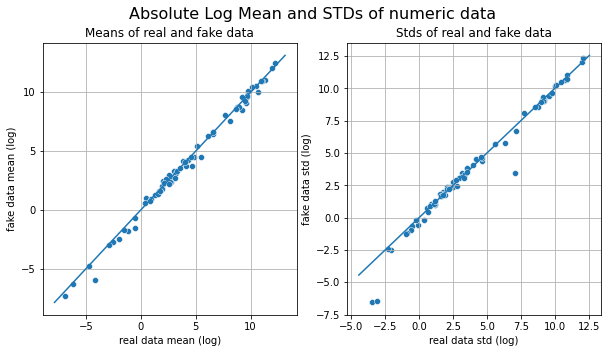

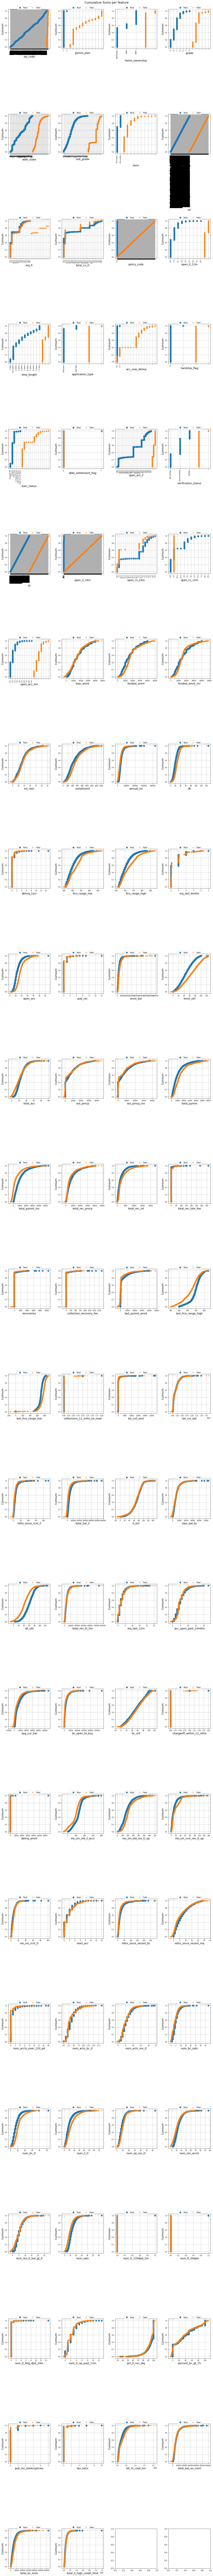

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


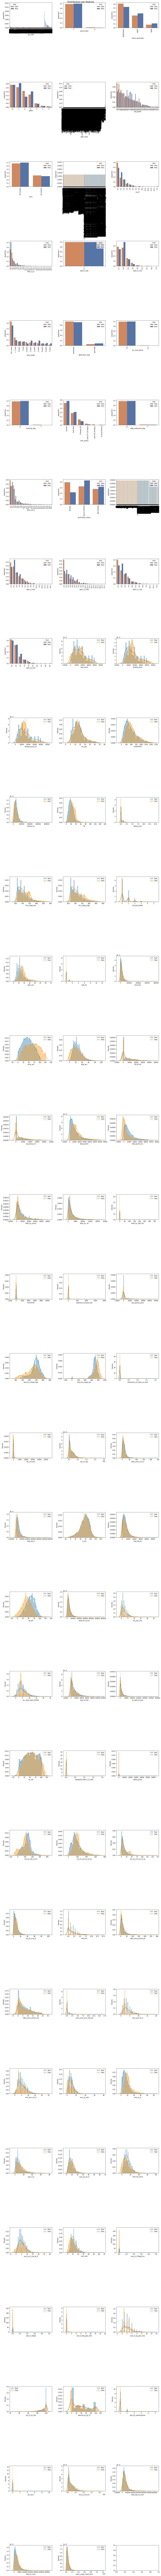

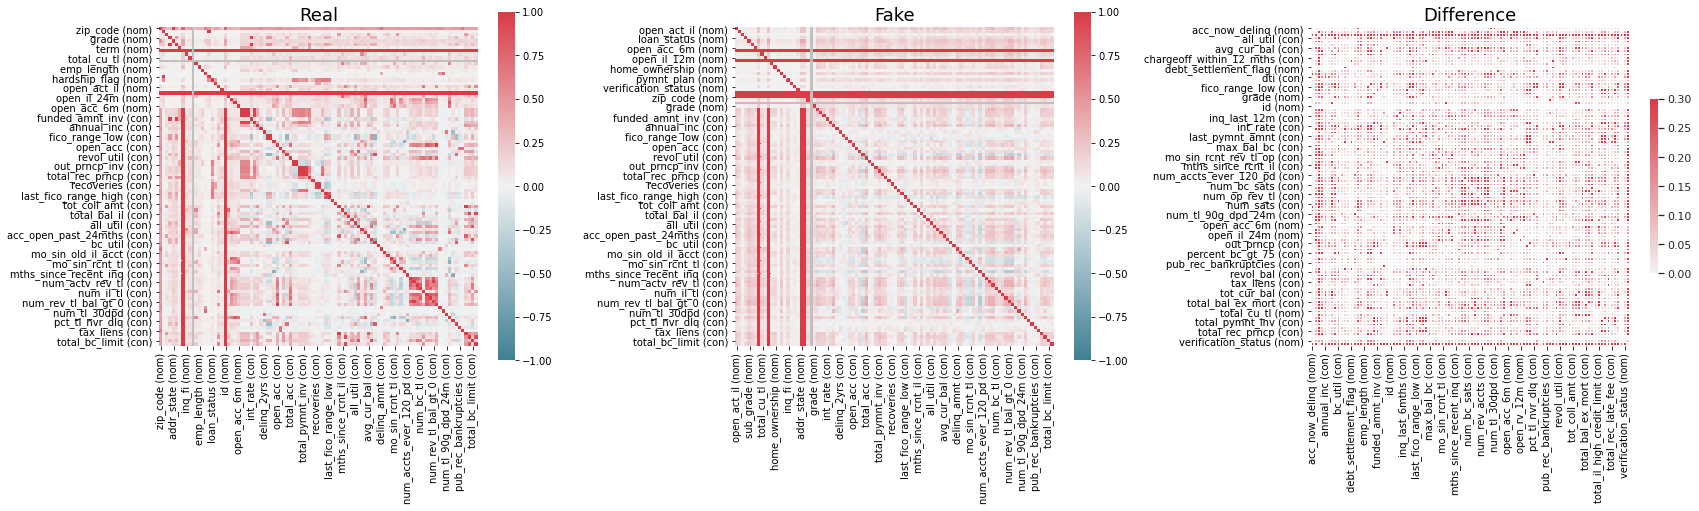

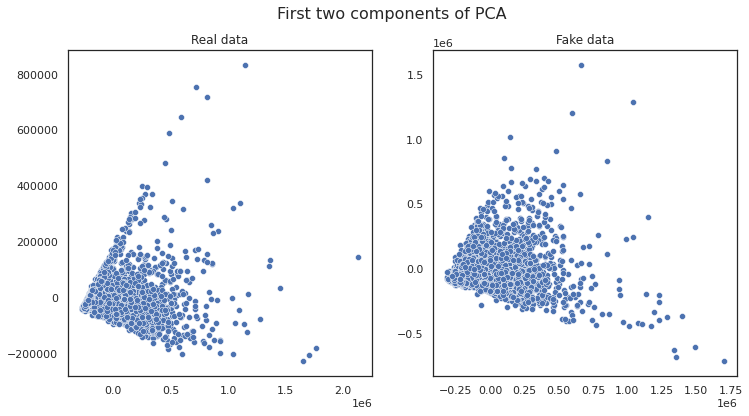

In [30]:
from table_evaluator import load_data, TableEvaluator

print(data.shape, syn_data.shape)
table_evaluator =  TableEvaluator(data, syn_data)

table_evaluator.visual_evaluation()

In [31]:
from sdv.tabular import TVAE

model_vae = TVAE(cuda = True,primary_key =primary_key,anonymize_fields = anonymize,epochs=500,compress_dims=(256, 256, 256),decompress_dims=(256, 256, 256))
model_vae.fit(data)

/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in

/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_ite

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in

In [32]:
model_vae.save('my_model_vae.pkl')

In [33]:
syn_data_vae = model_vae.sample(2912)
syn_data_vae.head(20)

zip_code pymnt_plan home_ownership grade  \
0     69072          n       MORTGAGE     C   
1     30112          n       MORTGAGE     B   
2     85891          n           RENT     E   
3     08591          n       MORTGAGE     A   
4     19906          n       MORTGAGE     C   
5     36597          n       MORTGAGE     C   
6     38189          n       MORTGAGE     C   
7     49242          n       MORTGAGE     C   
8     86325          n           RENT     B   
9     93054          n           RENT     C   
10    33531          n       MORTGAGE     A   
11    03978          n           RENT     B   
12    86514          n       MORTGAGE     C   
13    95389          n       MORTGAGE     C   
14    94169          n       MORTGAGE     A   
15    38790          n           RENT     B   
16    34857          n       MORTGAGE     C   
17    31021          n           RENT     C   
18    72039          n       MORTGAGE     D   
19    77522          n       MORTGAGE     A   

                                           addr_state sub_grade        term  \
0   49960 Odonnell Tunnel Suite 262\nNew Samuelche...        C2   60 months   
1    1321 Perkins Islands\nGallagherchester, MS 28601        B2   36 months   
2            025 Stokes Centers\nSouth Paul, TX 70933        D5   60 months   
3      65655 Huynh Plaza\nNorth Tamarashire, IL 79935        B2   36 months   
4                 2578 Ryan Pass\nKarenfort, IL 73850        C4   60 months   
5           931 Jeff Locks\nNorth Kelliport, GA 76152        C1   60 months   
6                    PSC 7575, Box 8880\nAPO AE 43753        C5   60 months   
7   99599 James Hills Suite 111\nLake Gregorytown,...        C1   60 months   
8   32799 Christopher Haven Apt. 007\nSouth Jeremy...        B2   36 months   
9        2992 Brown Village\nCarlsonchester, VA 92602        B5   36 months   
10  11630 Kari Rapids Apt. 478\nWest Deborahside, ...        A3   36 months   
11           38570 Ramos Springs\nAdamsport, VT 68385        B4   60 months   
12           679 Wendy Walks\nNew Karenstad, NY 16741        C4   60 months   
13          4057 Walls Square\nNorth Robert, DC 60541        C4   60 months   
14              311 Brown Shore\nLake Scott, GA 78615        A5   36 months   
15       76638 Young Mount\nEast Sarahhaven, IL 89402        B3   36 months   
16  82481 Mcclure Center Suite 594\nPollardchester...        B5   36 months   
17        547 Barbara Junction\nArnoldmouth, MN 03575        C5   36 months   
18  2907 Hendricks Throughway\nMyersborough, HI 61325        D3   36 months   
19    523 Neal River Suite 671\nThomasmouth, OR 82016        A4   36 months   

                                    url inq_fi total_cu_tl  ...  \
0      https://placeimg.com/933/883/any    2.0         0.0  ...   
1      https://placeimg.com/474/509/any    0.0         0.0  ...   
2        https://dummyimage.com/907x729    0.0         0.0  ...   
3    https://www.lorempixel.com/918/889    0.0         0.0  ...   
4    https://www.lorempixel.com/624/290    0.0         0.0  ...   
5      https://placeimg.com/210/223/any    0.0         0.0  ...   
6     https://www.lorempixel.com/462/48    0.0         0.0  ...   
7        https://dummyimage.com/717x108    0.0         0.0  ...   
8        https://dummyimage.com/383x578    0.0         0.0  ...   
9        https://dummyimage.com/948x537    0.0         0.0  ...   
10      https://placekitten.com/669/959    0.0         0.0  ...   
11  https://www.lorempixel.com/377/1024    0.0         0.0  ...   
12   https://www.lorempixel.com/288/528    0.0         0.0  ...   
13       https://placeimg.com/4/386/any    0.0         0.0  ...   
14     https://placeimg.com/132/189/any    0.0         0.0  ...   
15       https://placekitten.com/66/532    0.0         0.0  ...   
16     https://placeimg.com/377/105/any    1.0         0.0  ...   
17       https://dummyimage.com/613x590    0.0         0.0  ...   
18       https://dummyimage.com/216x744    0.0         0.0  ...   
19        https

(2912, 98) (2912, 98)


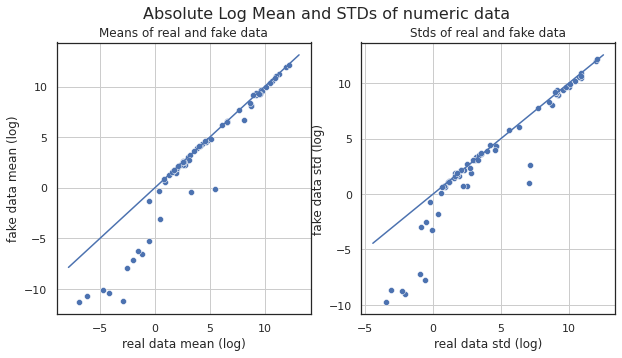

KeyboardInterrupt: 

In [34]:
from table_evaluator import load_data, TableEvaluator

print(data.shape, syn_data_vae.shape)
table_evaluator =  TableEvaluator(data, syn_data_vae)

table_evaluator.visual_evaluation()

In [35]:
data = data.reindex(columns = features)
syn_data = syn_data.reindex(columns = features)
syn_data_vae = syn_data_vae.reindex(columns = features)

In [36]:
syn_f = pd.concat([syn_data,syn_data_vae])

(2912, 98) (5824, 98)


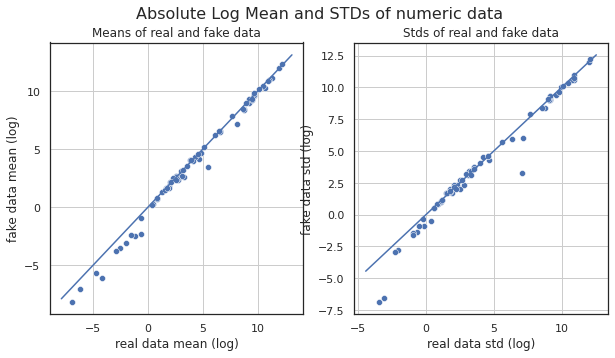

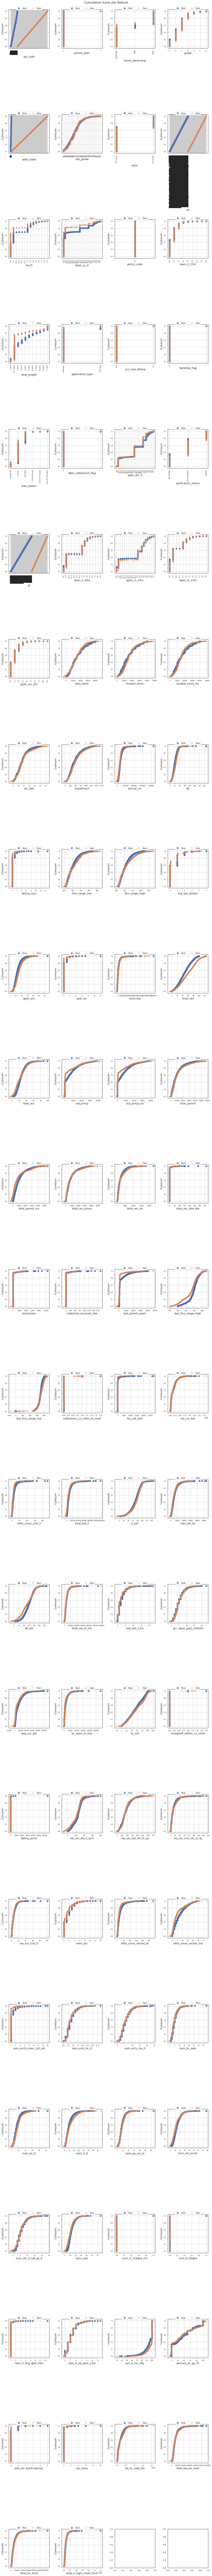

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

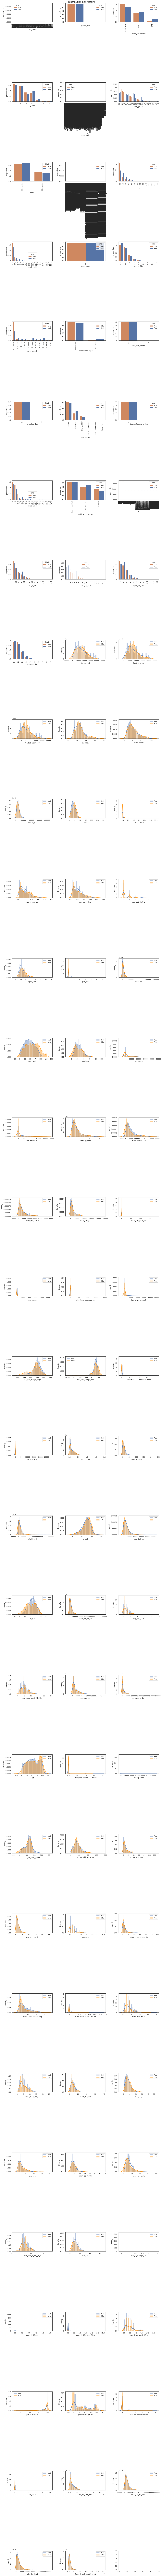

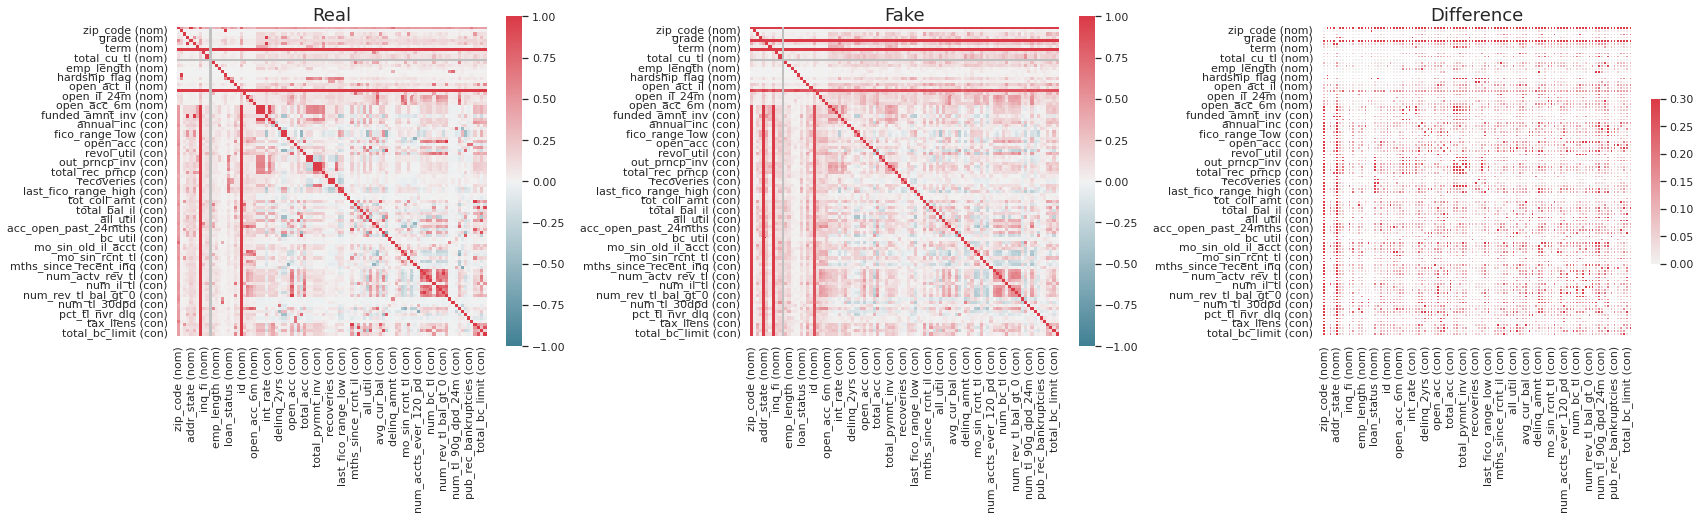

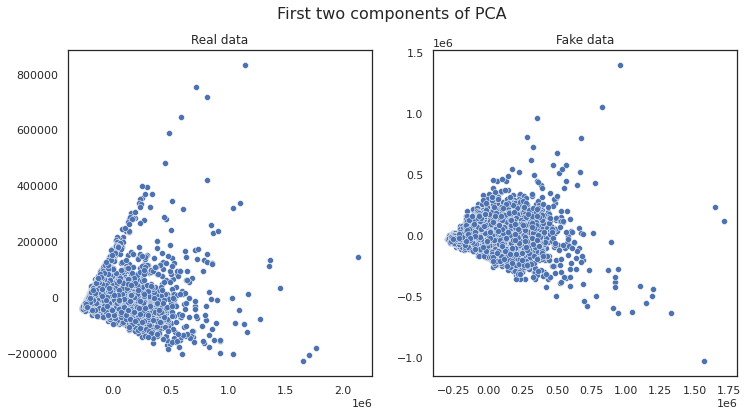

In [37]:
from table_evaluator import load_data, TableEvaluator

print(data.shape, syn_f.shape)
table_evaluator =  TableEvaluator(data, syn_f)

table_evaluator.visual_evaluation()

In [41]:
from sdv.evaluation import evaluate

evaluate(syn_data.drop(sensitive_fields+[primary_key],axis = 1), data.drop(sensitive_fields+[primary_key],axis = 1), metrics=['CSTest', 'KSTest'], aggregate=False)

metric                                     name  raw_score  \
0  CSTest                              Chi-Squared   0.951245   
1  KSTest  Inverted Kolmogorov-Smirnov D statistic   0.675796   

   normalized_score  min_value  max_value      goal  
0          0.951245        0.0        1.0  MAXIMIZE  
1          0.675796        0.0        1.0  MAXIMIZE

In [42]:
from sdv.evaluation import evaluate

evaluate(syn_data_vae.drop(sensitive_fields+[primary_key],axis = 1), data.drop(sensitive_fields+[primary_key],axis = 1), metrics=['CSTest', 'KSTest'], aggregate=False)

metric                                     name  raw_score  \
0  CSTest                              Chi-Squared   0.969284   
1  KSTest  Inverted Kolmogorov-Smirnov D statistic   0.758039   

   normalized_score  min_value  max_value      goal  
0          0.969284        0.0        1.0  MAXIMIZE  
1          0.758039        0.0        1.0  MAXIMIZE

In [43]:
from sdv.evaluation import evaluate

evaluate(syn_f.drop(sensitive_fields+[primary_key],axis = 1), data.drop(sensitive_fields+[primary_key],axis = 1), metrics=['CSTest', 'KSTest'], aggregate=False)

metric                                     name  raw_score  \
0  CSTest                              Chi-Squared   0.969260   
1  KSTest  Inverted Kolmogorov-Smirnov D statistic   0.757376   

   normalized_score  min_value  max_value      goal  
0          0.969260        0.0        1.0  MAXIMIZE  
1          0.757376        0.0        1.0  MAXIMIZE

In [ ]:
#df_nan_filtered.select(['revol_bal']).show()

In [ ]:
#spark.stop()

Substitution with fake data

In [ ]:
#df_nan_filtered.select(['addr_state']).show()

In [ ]:
'''from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from faker import Factory

def fake_name():
    faker = Factory.create()
    return faker.address()

fake_name_udf = udf(fake_name, StringType())
df_anon = df_nan_filtered.withColumn('addr_state', fake_name_udf())'''

In [ ]:
#df_anon.select(['addr_state']).show()